In [84]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from tqdm import tqdm
import acd
from copy import deepcopy
sys.path.append('vae')
from model import init_specific_model
from losses import Loss
from dset import get_dataloaders
from training import Trainer
from utils import *
import pickle as pkl
import pandas as pd
import seaborn as sns
from sim_gaussian_mixture import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
dirs = ["vary_lamb0_seed=13"]
results = []
models = []
for i in range(len(dirs)):
    # load results
    out_dir = opj("/home/ubuntu/transformation-importance/ex_gaussian_mixture/results", dirs[i])
    fnames = sorted(os.listdir(out_dir))

    results_list = []
    models_list = []
    for fname in fnames:
        if fname[-3:] == 'pkl':
            results_list.append(pkl.load(open(opj(out_dir, fname), 'rb')))
        if fname[-3:] == 'pth':
            model = init_specific_model(orig_dim=results_list[-1]['orig_dim'], 
                                        latent_dim=results_list[-1]['latent_dim'], 
                                        hidden_dim=results_list[-1]['hidden_dim']).to(device)
            model.load_state_dict(torch.load(opj(out_dir, fname)))
            models_list.append(model)
            
    results.append(pd.DataFrame(results_list))
    models.append(models_list)

## Plotting results

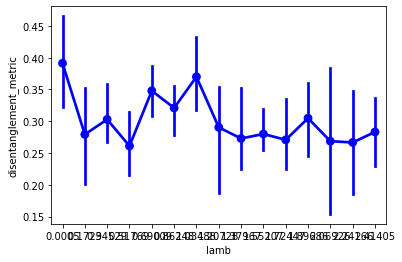

In [91]:
ax0 = sns.pointplot(x='lamb', y='disentanglement_metric', hue=None, data=results[0], color='blue')
# ax1 = sns.pointplot(x='beta', y='disentanglement_metric', hue=None, data=results[1], color='red')
# ax1.set_title('disentanglement metric')

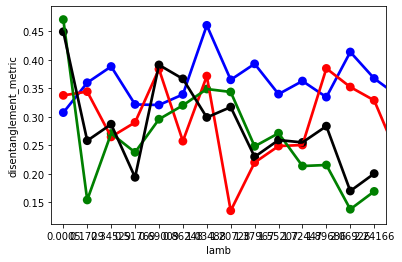

In [77]:
x = results[0].loc[results[0]['mu']==0., 'lamb']
y = results[0].loc[results[0]['mu']==0., 'disentanglement_metric']
ax0 = sns.pointplot(x, y, color='blue')
x = results[0].loc[results[0]['mu']==0.001, 'lamb']
y = results[0].loc[results[0]['mu']==0.001, 'disentanglement_metric']
ax1 = sns.pointplot(x, y, color='red')
x = results[0].loc[results[0]['mu']==0.01, 'lamb']
y = results[0].loc[results[0]['mu']==0.01, 'disentanglement_metric']
ax2 = sns.pointplot(x, y, color='green')
x = results[0].loc[results[0]['mu']==0.05, 'lamb']
y = results[0].loc[results[0]['mu']==0.05, 'disentanglement_metric']
ax3 = sns.pointplot(x, y, color='black')

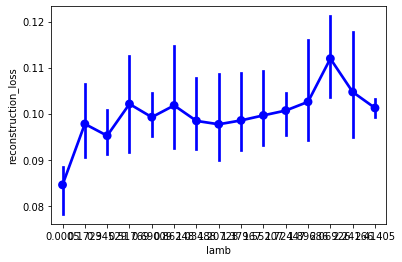

In [78]:
ax0 = sns.pointplot(x='lamb', y='reconstruction_loss', hue=None, data=results[0], color='blue')
# ax1 = sns.pointplot(x='beta', y='reconstruction_loss', hue=None, data=results[1], color='red')
# ax1.set_title('reconstruction loss')

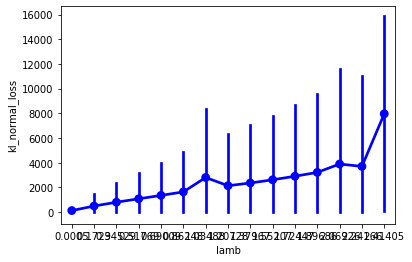

In [79]:
ax0 = sns.pointplot(x='lamb', y='kl_normal_loss', hue=None, data=results[0], color='blue')
# ax1 = sns.pointplot(x='beta', y='kl_normal_loss', hue=None, data=results[1], color='red')
# ax1.set_title('kl penalty')

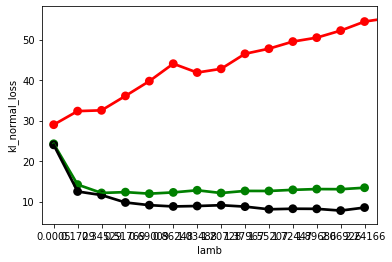

In [81]:
# x = results[0].loc[results[0]['mu']==0., 'lamb']
# y = results[0].loc[results[0]['mu']==0., 'kl_normal_loss']
# ax0 = sns.pointplot(x, y, color='blue')
x = results[0].loc[results[0]['mu']==0.001, 'lamb']
y = results[0].loc[results[0]['mu']==0.001, 'kl_normal_loss']
ax1 = sns.pointplot(x, y, color='red')
x = results[0].loc[results[0]['mu']==0.01, 'lamb']
y = results[0].loc[results[0]['mu']==0.01, 'kl_normal_loss']
ax2 = sns.pointplot(x, y, color='green')
x = results[0].loc[results[0]['mu']==0.05, 'lamb']
y = results[0].loc[results[0]['mu']==0.05, 'kl_normal_loss']
ax3 = sns.pointplot(x, y, color='black')

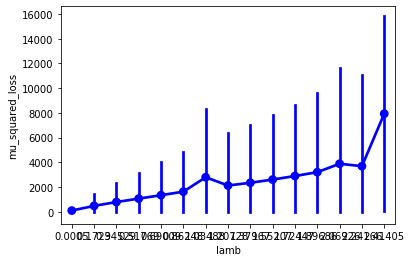

In [82]:
ax0 = sns.pointplot(x='lamb', y='mu_squared_loss', hue=None, data=results[0], color='blue')
# ax1 = sns.pointplot(x='beta', y='mu_squared_loss', hue=None, data=results[1], color='red')
# ax1.set_title('mu squared loss')

In [ ]:
ax0 = sns.pointplot(x='lamb', y='total_correlation', hue=None, data=results[0], color='blue')
ax1 = sns.pointplot(x='beta', y='total_correlation', hue=None, data=results[1], color='red')
ax1.set_title('total correlation')

In [ ]:
ax0 = sns.pointplot(x='lamb', y='mutual_information', hue=None, data=results[0], color='blue')
ax1 = sns.pointplot(x='beta', y='mutual_information', hue=None, data=results[1], color='red')
ax1.set_title('mutual information')

In [ ]:
ax0 = sns.pointplot(x='lamb', y='dimensionwise_kl_loss', hue=None, data=results[0], color='blue')
ax1 = sns.pointplot(x='beta', y='dimensionwise_kl_loss', hue=None, data=results[1], color='red')
ax1.set_title('dimensionwise kl')

In [ ]:
ax0 = sns.pointplot(x='lamb', y='local_independence_loss', hue=None, data=results[0], color='blue')
ax1 = sns.pointplot(x='beta', y='local_independence_loss', hue=None, data=results[1], color='red')
ax1.set_title('local_independence_loss loss')

## Visualization

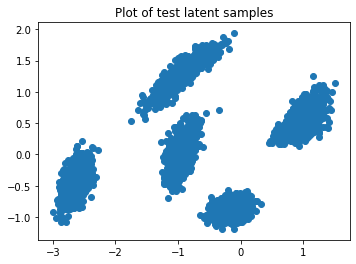

In [88]:
# GET MODEL AND RESULT
idx = 15
model = models[0][idx]
result = results[0].loc[idx]

params_to_vary = ['num_epochs', 'seed', 'hidden_dim', 'eps', 'beta', 'mu', 'lamb', 'dirname', 'latent_means', 'latent_vars']
for name in params_to_vary:
    setattr(p, name, result[name])
    
# SEED
random.seed(p.seed)
np.random.seed(p.seed)
torch.manual_seed(p.seed)    

# GET DATALOADERS
(_, _), (test_loader, test_latents) = define_dataloaders(p)

# EVALUATE TEST DATA
data = test_loader.dataset.data.to(device)
recon_data, latent_dist, latent_sample = model(data)
plot_2d_latent_samples(latent_sample)
plt.title("Plot of test latent samples")
plt.show()

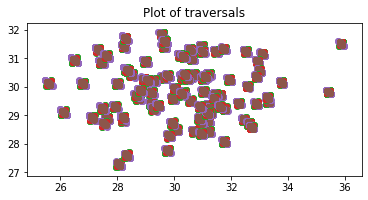

In [90]:
plot_traversals(model, data, lb=2000, ub=3000, num=100)
plt.title("Plot of traversals")
plt.show()

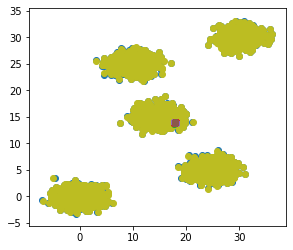

In [87]:
plot_traversals(model, data, lb=0, ub=2000, num=1,
                draw_data=True, draw_recon=True)